In [106]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
from scipy.fft import fft
import math
import random

In [107]:
###...........DFT 0 Method...........###

# Generate s_tone(n)
def generate_s_tone(Fs, f0, phi0, M):
    n = np.arange(M)
    s_tone = np.cos((2 * np.pi * f0 * n )/Fs + phi0)
    return n, s_tone

# Estimate frequency and phase with DFT⁰
def estimate_frequency_and_phase(s_tone, Fs, M, N_DFT, window_type):
    
    window = get_window(window_type, M)
    s_tone = s_tone * window

    # Zero-pad the signal to length N_DFT
    s_tone_padded = np.pad(s_tone, (0, N_DFT - M), 'constant')

    # Compute the DFT
    X = fft(s_tone_padded, N_DFT)

    # Find the peak in the magnitude spectrum
    magnitude_spectrum = np.abs(X) # Magnitude of the DFT (Amplitude)
    k_max = np.argmax(magnitude_spectrum) # Maximum Amplitude
    f0_estimated = k_max*(Fs)/(N_DFT) # estimated frequency of the single tone

    # Estimate the phase
    phi0_estimated = np.angle(X[k_max]) # Argument (angle) of the DFT function

    return f0_estimated, phi0_estimated


###...........DFT 1 Method...........###

def estimate_frequency_and_phase_derivative(s_tone, Fs, M, N_DFT, window_type):

    ###......Estimate the frequency......###
    s_tone_unmodified = s_tone
    # Get the window type
    window = get_window(window_type, M-1)
    
    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), 'constant')
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), 'constant')

    # Calculate the DFT
    X = fft(s_tone_padded,n=N_DFT)
    X_diff = fft(s_tone_padded_diff,n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)
    #k_max_diff = np.argmax(abs_X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max/ N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])
    print(f"f_DFT1: {f0_estimated}")

    # Validate the frequency result
    k_DFT = (N_DFT * f0_estimated) / Fs
    if k_DFT >= (k_max - 0.5) and k_DFT < (k_max + 0.5):
        print("estimated freq. is valid")


    ###......Estimate the phase......###
    # Calculate phase with DFT⁰ method to compare the values
    f0_DFT0, phi_DFT0 = estimate_frequency_and_phase(s_tone_unmodified, Fs, M, N_DFT, window_type)

    #omega_0 = (2 * np.pi * f0_estimated) / Fs
    omega_0 = 2*np.pi*f0_estimated/Fs
    k_low = math.floor(k_DFT)
    k_high = math.ceil(k_DFT)

    theta_low = np.angle(X_diff[k_low])
    theta_high = np.angle(X_diff[k_high])
    theta = (k_DFT - k_low) * (theta_high - theta_low) / (k_high - k_low) + theta_low

    numerator = np.tan(theta) * (1 - np.cos(omega_0)) + np.sin(omega_0)
    denominator = 1 - np.cos(omega_0) - np.tan(theta) * np.sin(omega_0)
    phase_estimated = np.arctan(numerator/denominator)
    print(f"f_DFT1: {phase_estimated}")
    
    # Calculate both possible values of phi and compare them
    phi_1 = phase_estimated 
    phi_2 = phase_estimated + np.pi if np.arctan(phase_estimated) >= 0 else phase_estimated - np.pi

    if abs(phi_1 - phi_DFT0) < abs(phi_2 - phi_DFT0):  # compare with phi calculated via DFT⁰
        phi = phi_1
    else:
        phi = phi_2

    return f0_estimated, phase_estimated


def relative_freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)/freq * 100

def phase_err(phase, estimate_phase):
    return np.abs(phase-estimate_phase)

def generate_random_number(min_value, max_value, decimal_places):
    number = random.uniform(min_value, max_value)
    formatted_number = round(number, decimal_places)
    return formatted_number

def create_tones():
    # Generate random sinus waves
    lower_bound_freq = 59.0 # in Hz
    upper_bound_freq = 61.0
    toneSample_num = 1000
    N_periods = 600
    Fs = 1200
    Ds = 10 # 10s Audiodatei
    M = Fs * Ds # Sample number 

    frequencies = []
    for i in range(toneSample_num):
        frequencies.append(generate_random_number(lower_bound_freq, upper_bound_freq, 2))
    frequencies = np.array(frequencies)

    phases = []
    for i in range(toneSample_num):
        phases.append(generate_random_number(0, 2*np.pi, 2))
    phases = np.array(phases)

    s_tones = []
    for i in range (len(frequencies)):
        n, s_tone = generate_s_tone(Fs, frequencies[i], phases[i], M)
        s_tones.append(s_tone)
    tones = np.array(s_tones)

    period_length = Fs/f0
    cut_tones = []
    cut_coords = []

    for i in range(len(frequencies)):
        period_length = math.floor(Fs/frequencies[i])
        start_num = int(generate_random_number(0, M-period_length, 0)) # Random number between 0 and N - (period length)
        end_num = generate_random_number(0, (period_length-1) , 0) # Random number between 1 and period_length-1)
        end_num = int(start_num + end_num)
        cut_coords.append(start_num)
        cut_tones.append(np.concatenate((tones[i][:start_num], tones[i][end_num:])))

    return frequencies, phases, tones, cut_tones, cut_coords



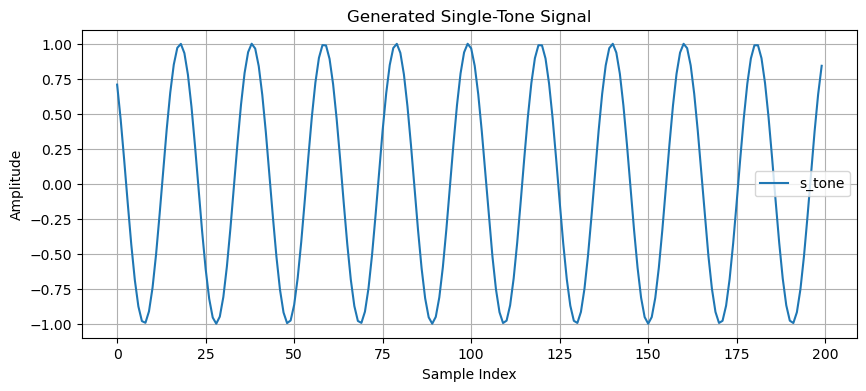

Estimated frequency: 58.998 Hz
Estimated phase: 0.7864271939858908 radians


In [108]:
# Example usage
Fs = 1200 # Sampling frequency (Hz)
f0 = 59  # Frequency of the tone (Hz)
phi0 = np.pi/4  # Phase of the tone (radians)
M = 200 # Number of samples
N_DFT = 200000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n, s_tone, label='s_tone')
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.show()

# Estimate frequency and phase
f0_estimated, phi0_estimated = estimate_frequency_and_phase(s_tone, Fs, M, N_DFT, window_type)
print(f"Estimated frequency: {f0_estimated} Hz")
print(f"Estimated phase: {phi0_estimated} radians")

In [109]:
# Example usage
Fs = 1200 # Sampling frequency (Hz)
f0 = 60.89 # Frequency of the tone (Hz)
phi0 = np.pi/4 # Phase of the tone (radians)
M =  200 # Number of samples
N_DFT = 20000
window_type = 'hann'  # Optional window type (e.g., 'hann', 'hamming', etc.)

# Generate the signal
n, s_tone = generate_s_tone(Fs, f0, phi0, M)

frequency_estimated, phase_estimated = estimate_frequency_and_phase_derivative(s_tone, Fs, M, N_DFT, window_type)
print(f"Estimated frequency: {frequency_estimated:.6f} Hz")
print(f"Estimated phase: {phase_estimated:.6f} radians")


f_DFT1: 60.88769115800795
estimated freq. is valid
f_DFT1: 0.7865938098311682
Estimated frequency: 60.887691 Hz
Estimated phase: 0.786594 radians


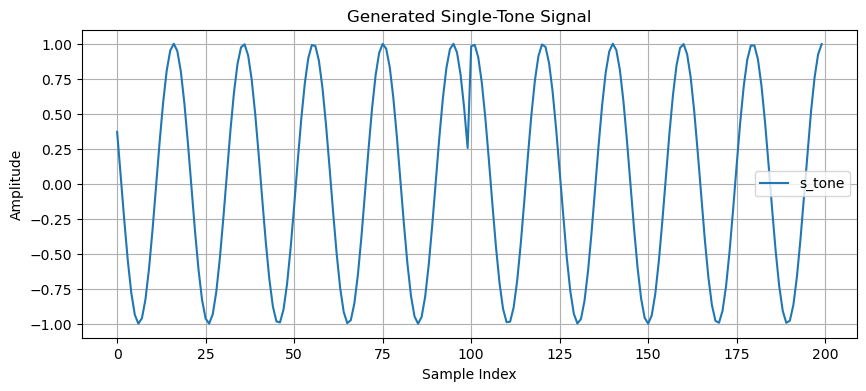

In [110]:
# Show one cut as example
_,_,_,tones_array,cut_coords = create_tones()

specific_tones_array = tones_array[0][cut_coords[0]-100:cut_coords[0]+100]
n = np.arange(200)

#Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(n, specific_tones_array, label='s_tone')
plt.title('Generated Single-Tone Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.show()